In [1]:
import numpy as np
from scipy.optimize import curve_fit
import ROOT

from tqdm import tqdm, trange
import matplotlib.pyplot as plt

ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetHistLineWidth(2)

ROOT.gStyle.SetPadLeftMargin(0.15);
ROOT.gStyle.SetPadRightMargin(0.15);
ROOT.gStyle.SetPadBottomMargin(0.10); 

Welcome to JupyROOT 6.26/10


In [2]:
# read in file
import os
file_name = "/media/linux_store/hep/data/ES_gvkm/ES_gvkm_radiological_0201.root"
# file_name = f"/media/linux_store/hep/data/ES_gvkm/ES_gvkm_clean_0127.root"
# file_name = f"/media/linux_store/hep/data/CC_gvkm/CC_gvkm_radiological_0201.root"
file = ROOT.TFile(file_name)
tree=file.PointResTree.tr

In [3]:
# loop through file
# define linear coefficients for energy reconstruction
def charge_to_energy_clean(charge):
    m = 248.111
    b = 2161.06
    return (charge - b)/m

cosAngle_list = []
sample_size_per_bin = []
nbin_en = 7
e_max = 70
nbin_cosangle = 20
pdf = np.zeros([nbin_en, nbin_cosangle])
for e in tqdm(tree, total=tree.GetEntries()):
    if e.NTrks==0: continue
    en = charge_to_energy_clean(e.charge_corrected)
    if en > e_max: en = e_max-0.001
    cosAngle = e.truth_nu_dir.Dot(e.reco_e_dir)
    en_binidx = int(en//(e_max/nbin_en)) if en > 0 else 0
    cosangle_binidx = int((cosAngle+1)//(2/nbin_cosangle))
    pdf[en_binidx, cosangle_binidx]+=1
# normalize pdf for each energy bin
pdf_error = np.sqrt(pdf)

for i in range(len(pdf)):
    energy_slice = pdf[i]
    sample_size_per_bin.append(np.sum(pdf[i]))
    scale = np.sum(pdf[i])/nbin_cosangle*2
    pdf[i] = pdf[i] / scale
    pdf_error[i] /= scale
# np.savetxt('ES_gvkm_radiological.dat', pdf)

100%|██████████████████████████████████████████████████████████████████████| 1148750/1148750 [00:17<00:00, 66389.98it/s]


In [42]:
nbin_cosangle_fine = nbin_cosangle*50
pdf_fine = np.zeros([nbin_en, nbin_cosangle_fine])
for e in tqdm(tree, total=tree.GetEntries()):
    if e.NTrks==0: continue
    en = charge_to_energy_clean(e.charge_corrected)
    if en > e_max: continue
    cosAngle = e.truth_nu_dir.Dot(e.reco_e_dir)
    en_binidx = int(en//(e_max/nbin_en)) if en > 0 else 0
    cosangle_binidx = int((cosAngle+1)//(2/nbin_cosangle_fine))
    pdf_fine[en_binidx, cosangle_binidx]+=1
pdf_fine_error = np.sqrt(pdf_fine)
for i in range(len(pdf_fine)):
    energy_slice = pdf_fine[i]
    sample_size_per_bin.append(np.sum(pdf_fine[i]))
    scale = np.sum(pdf_fine[i])
    pdf_fine[i] = pdf_fine[i] / scale
    pdf_fine_error[i] /= scale
pdf_fine *= 50
pdf_fine_error *= 50

100%|███████████████████████████████████████████████████████| 1148750/1148750 [00:16<00:00, 70819.15it/s]


Text(0, 0.5, '$e^-$ energy (MeV)')

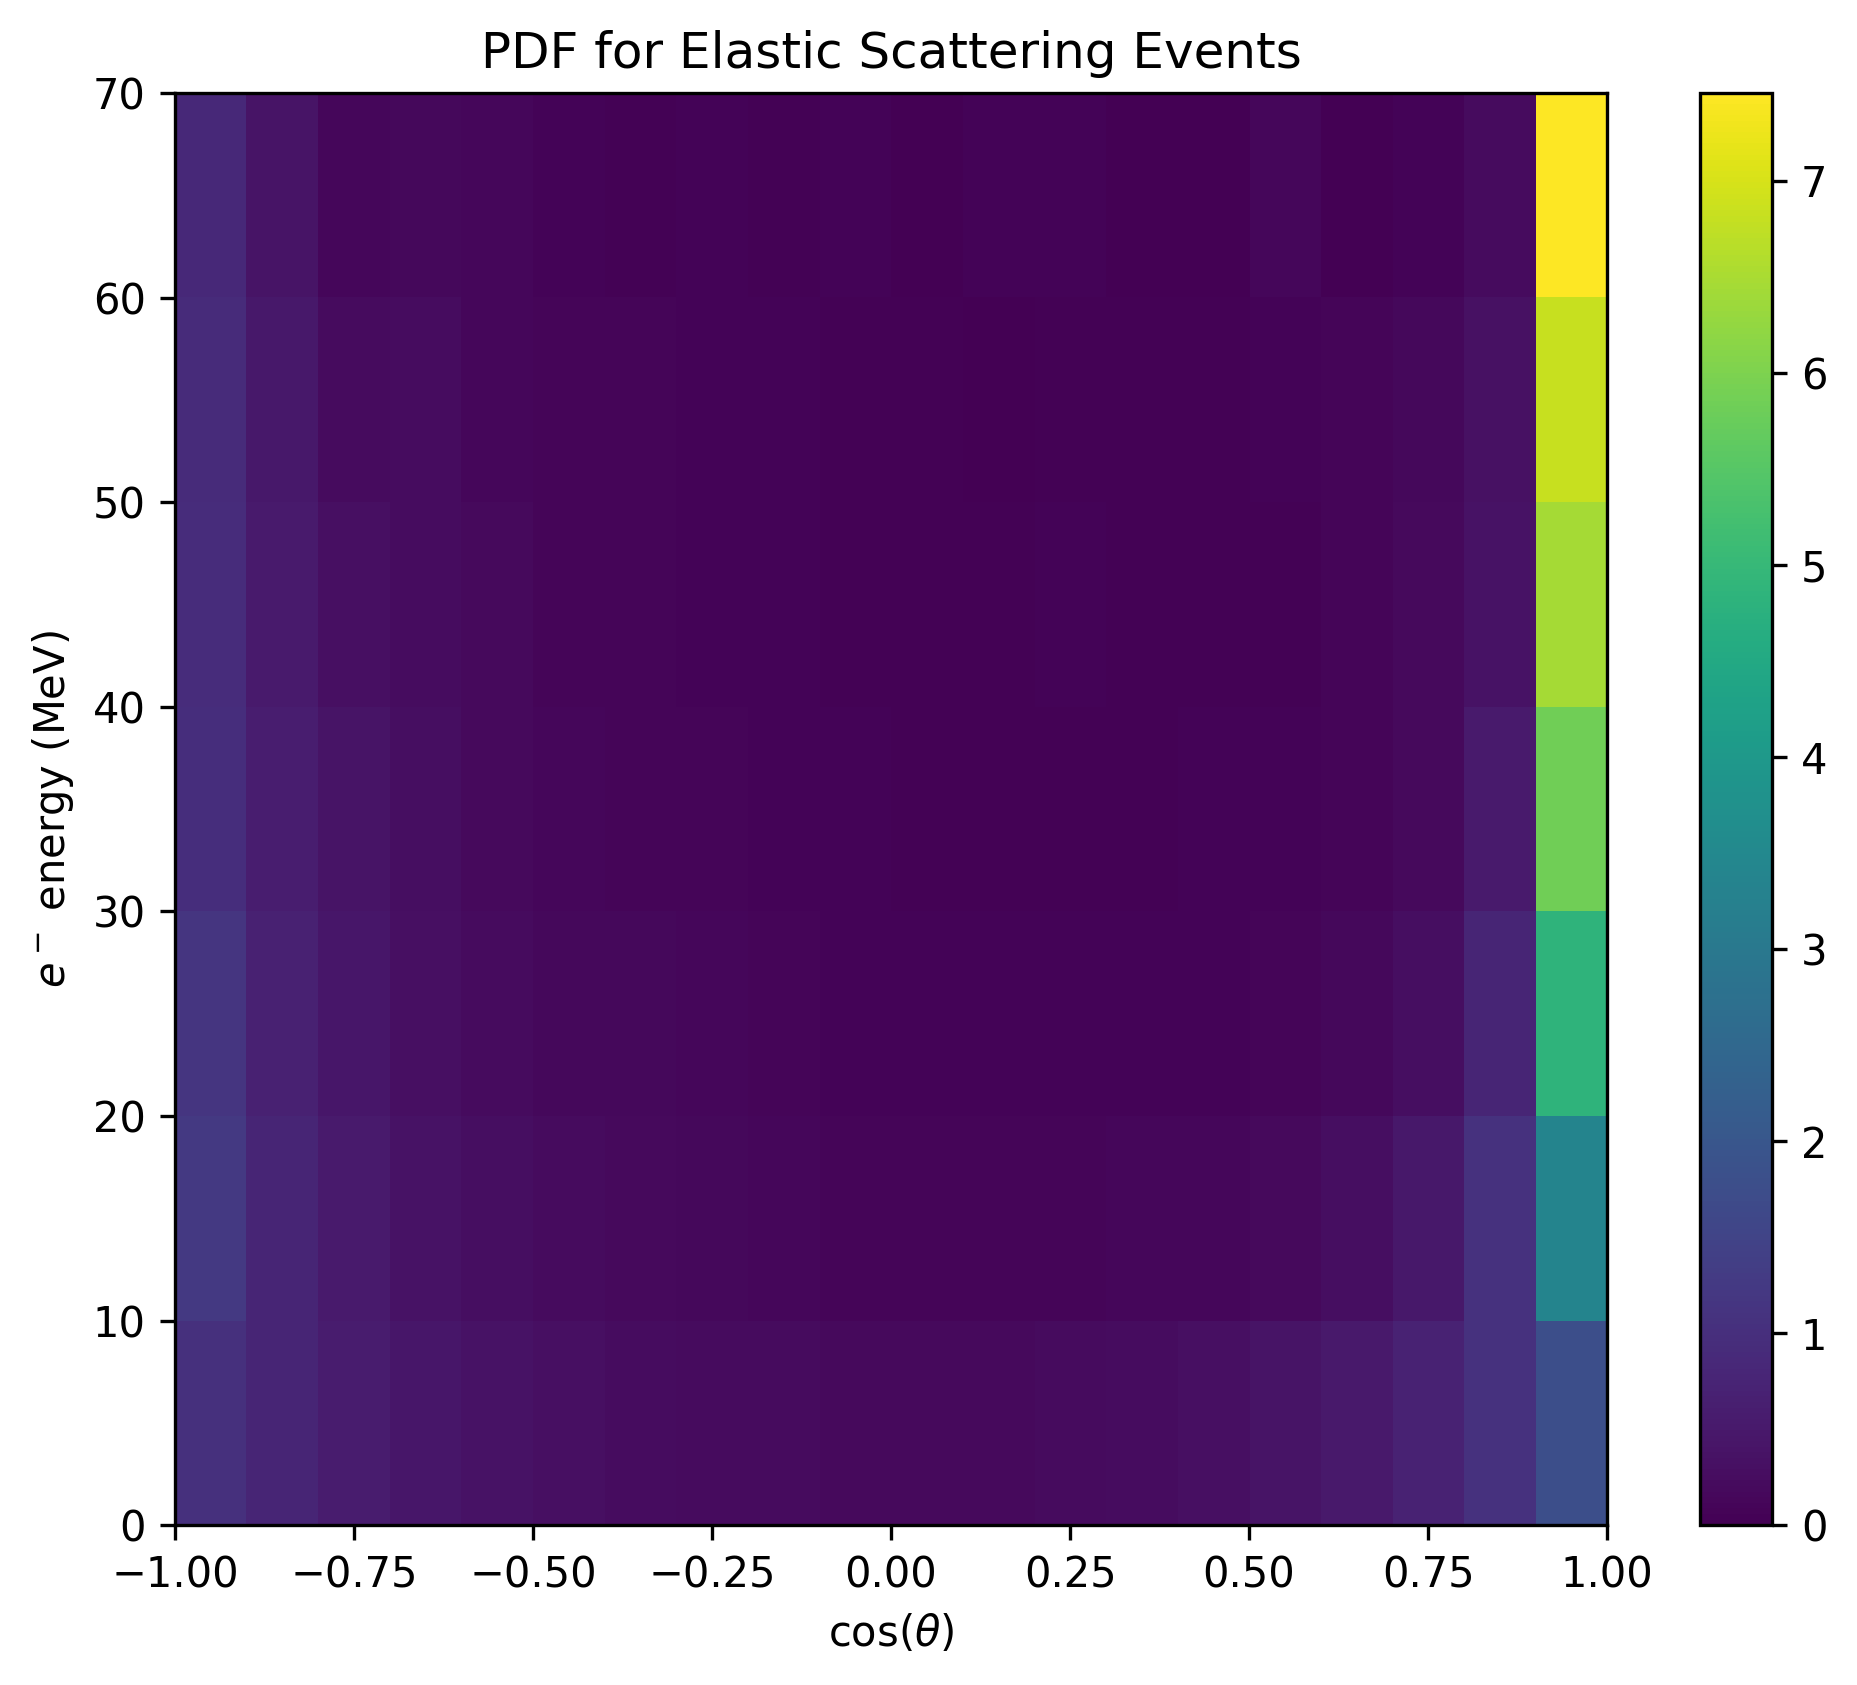

In [8]:
fig, ax = plt.subplots(figsize=(8, 6.2), dpi=300)

image = ax.imshow(pdf, extent=[-1,1,0,e_max], aspect=2/70, origin='lower')
ax.set_title("PDF for Elastic Scattering Events")
# ax.set_title("PDF for CC Events")
ax.set_xlabel(r'$\cos(\theta)$')
fig.colorbar(image, ax=ax)
ax.set_ylabel(r'$e^-$ energy (MeV)')
# fig.savefig(f'/media/linux_store/hep/plots/CC_pdf/ES_pdf_2d.eps', format='eps')

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6.2), dpi=300)

image = ax.imshow(pdf, extent=[-1,1,0,e_max], aspect=2/70, origin='lower')
ax.set_title("PDF for Elastic Scattering Events")
# ax.set_title("PDF for CC Events")
ax.set_xlabel(r'$\cos(\theta)$')
fig.colorbar(image, ax=ax)
ax.set_ylabel(r'$e^-$ energy (MeV)')
# fig.savefig(f'/media/linux_store/hep/plots/CC_pdf/ES_pdf_2d.eps', format='eps')

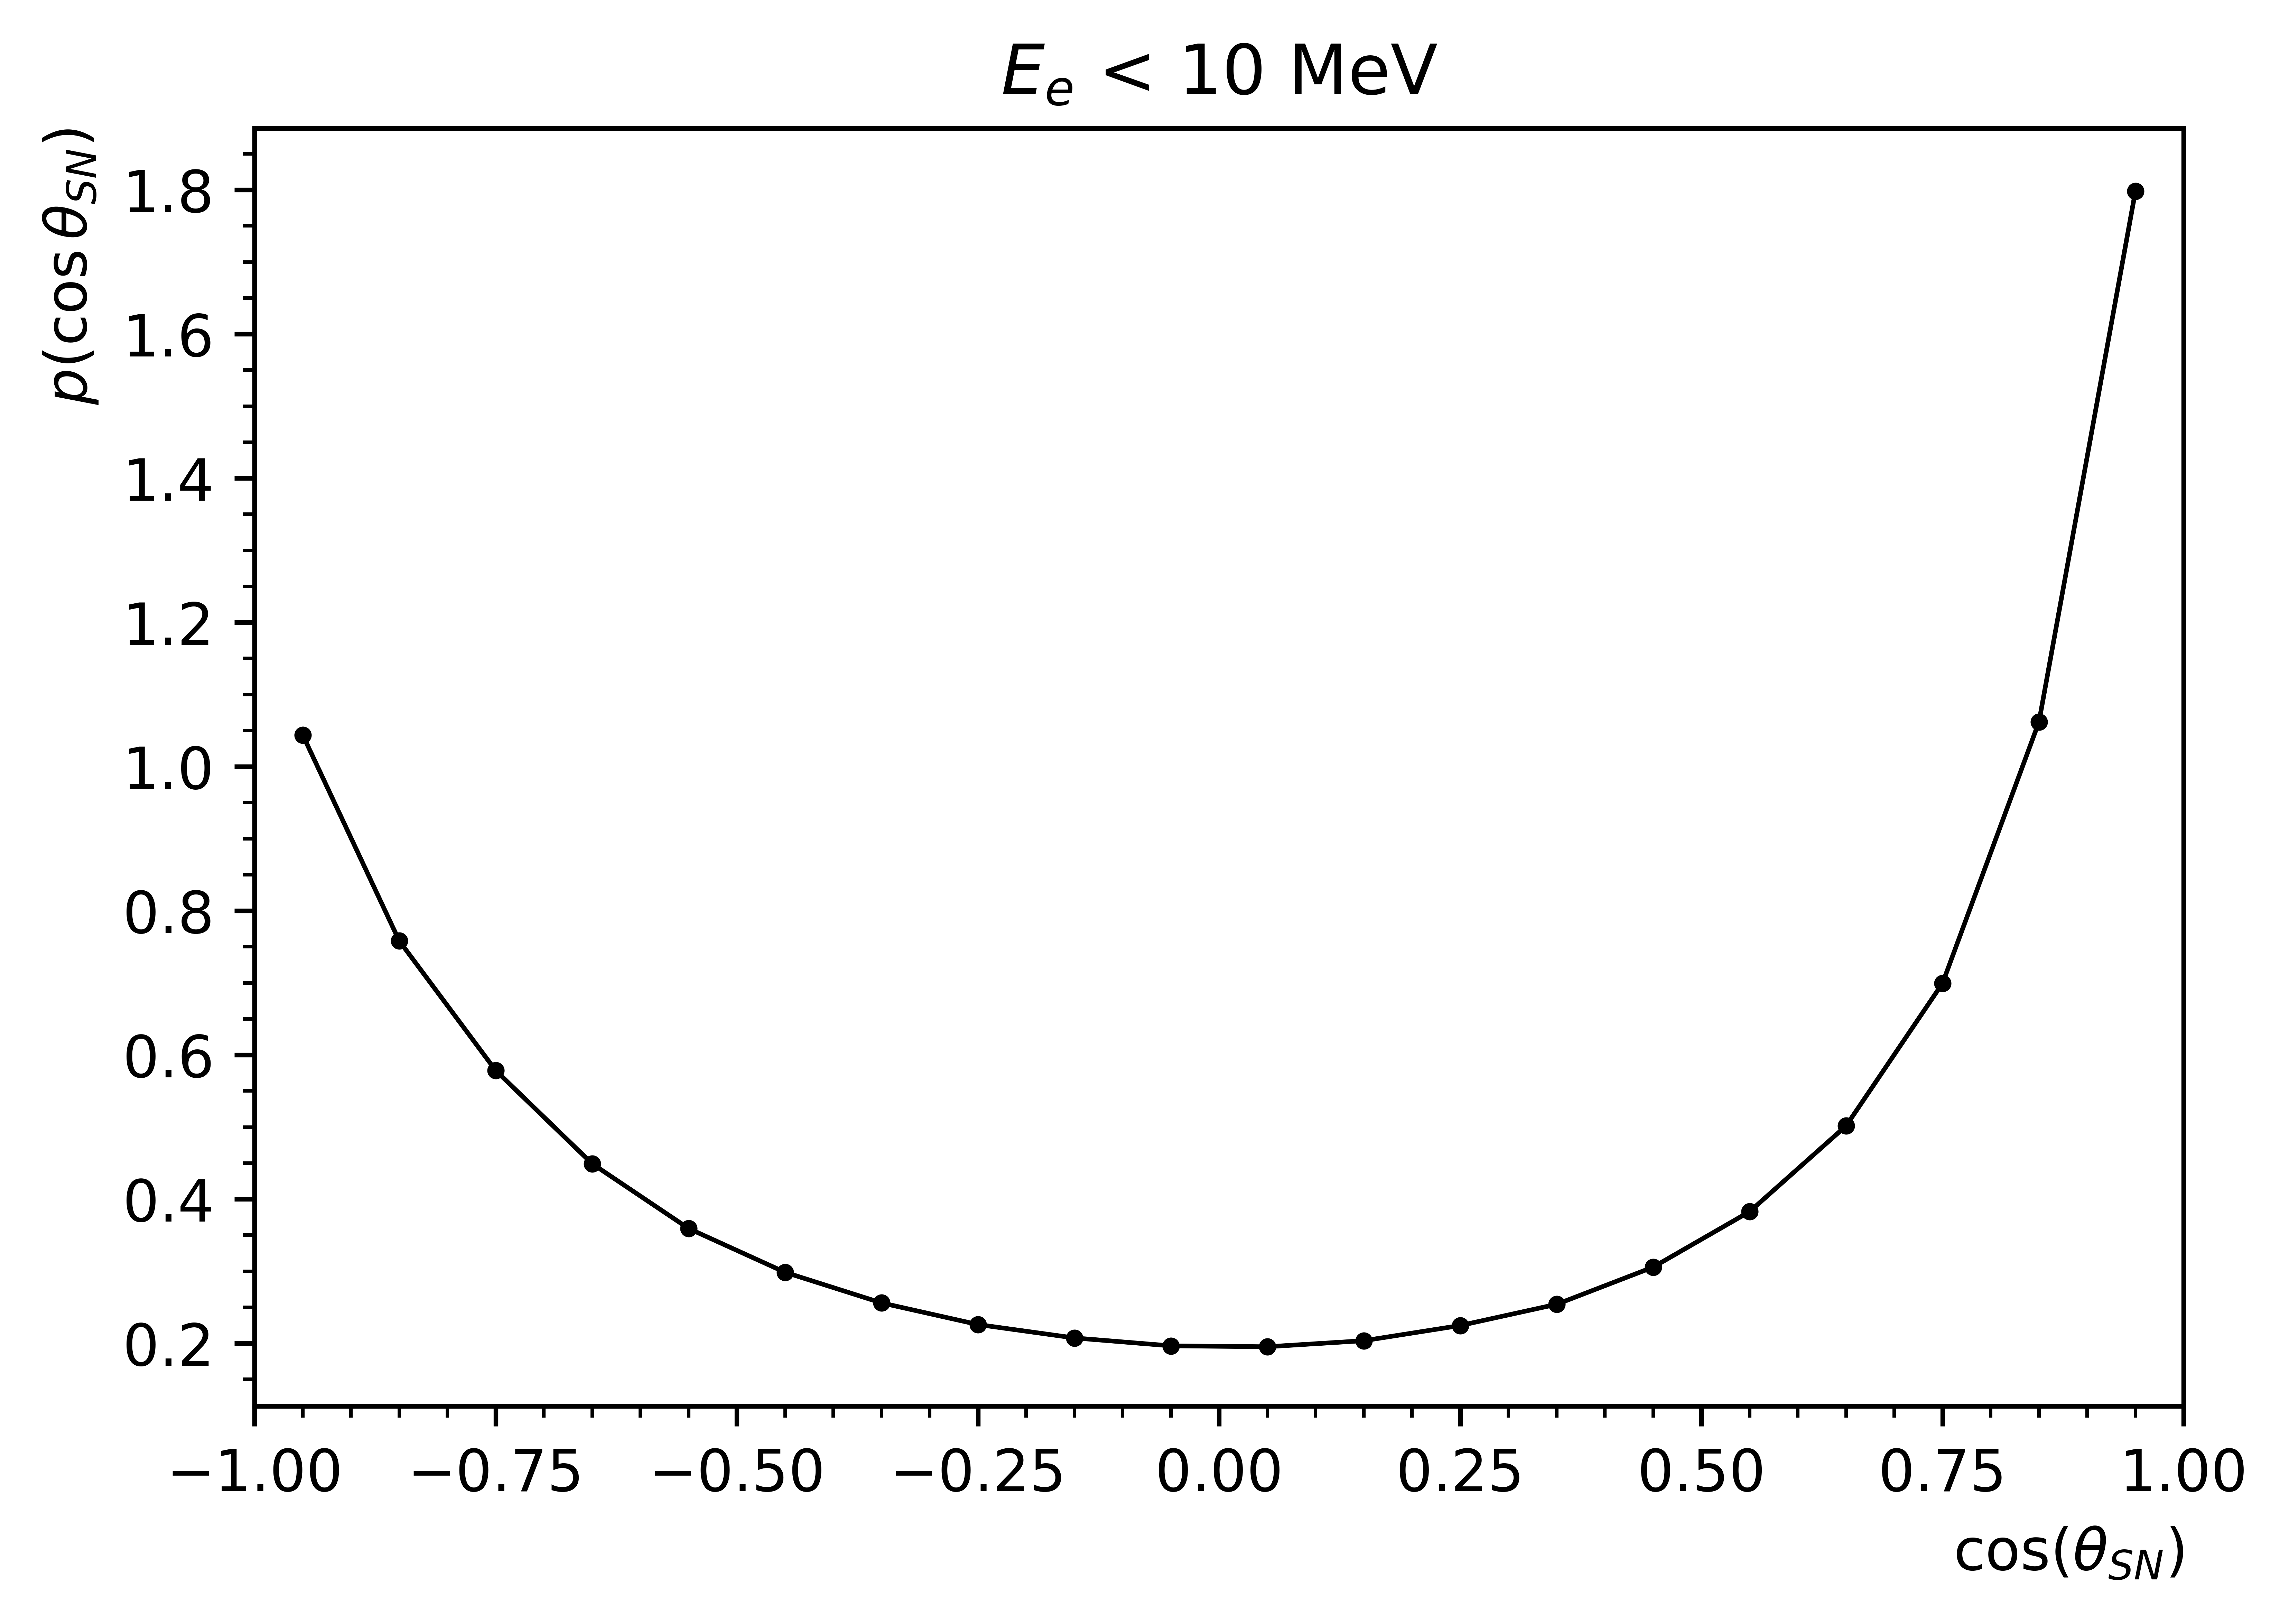

In [ ]:
from scipy.interpolate import make_interp_spline
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

# energy slices
cosAngle_bins = np.linspace(-1, 1, num=20, endpoint=False) + 2/20/2
cosAngle_bins_fine = np.linspace(-1, 1, num=20*50, endpoint=False) + 2/20/2
# print(cosAngle_bins)
for i, (pdf_slice, pdf_error_slice) in enumerate(zip(pdf, pdf_error)):
    f = plt.figure(figsize=(6, 4), dpi=1200)    
    ax = f.add_subplot(111)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    plt.title(f"{i*10} MeV < $E_e$ < {(i+1)*10} MeV")
    if i == 6:
        plt.title(f"$E_e$ > 60 MeV")
    if i == 0:
        plt.title(f"$E_e$ < 10 MeV")
    plt.xlabel(r'$\cos(\theta_{SN})$', loc='right')
    plt.ylabel(r'$p(\cos\theta_{SN})$', loc='top')
#     plt.xlabel(r'$\hat{d}_{SN} \cdot \hat{d}_{i}$', loc='right')
#     plt.ylabel(r'$p(\hat{d}_{i}; \hat{d}_{SN})$', loc='top')
    plt.xlim(-1, 1)
#     plt.ylim([0.4, 0.6])

    
#     model=make_interp_spline(cosAngle_bins, pdf_slice)
#     xs=np.linspace(cosAngle_bins[0],cosAngle_bins[-1],500)
#     ys=model(xs)

#     plt.plot(xs, ys, 'k')
    plt.errorbar(cosAngle_bins, pdf_slice, fmt='.k-', yerr=pdf_error_slice, markersize=4, linewidth=0.8)
    plt.savefig(f'/media/linux_store/hep/plots/ES_pdf/{i*10}-{(i+1)*10}.eps', format='eps')



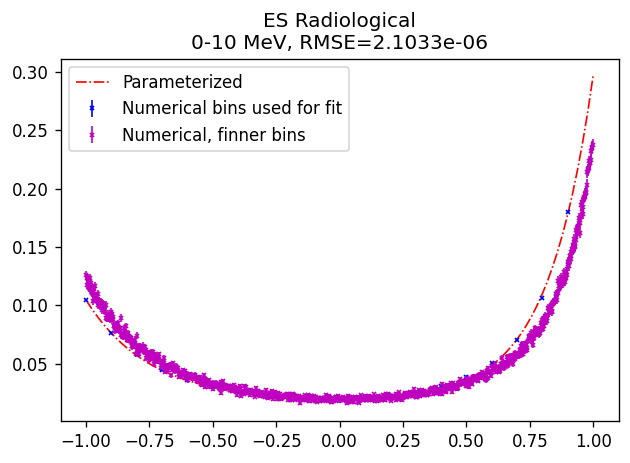

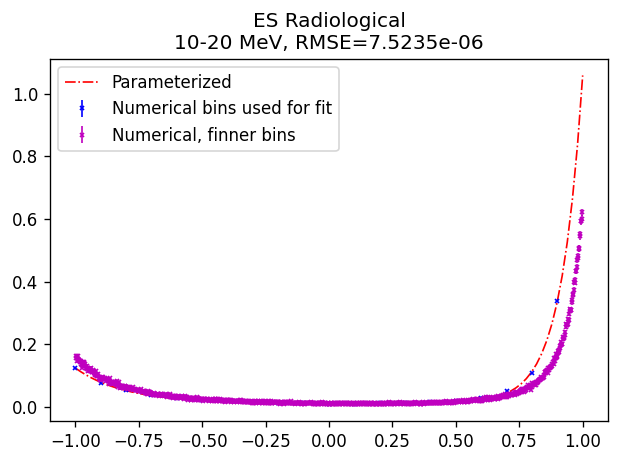

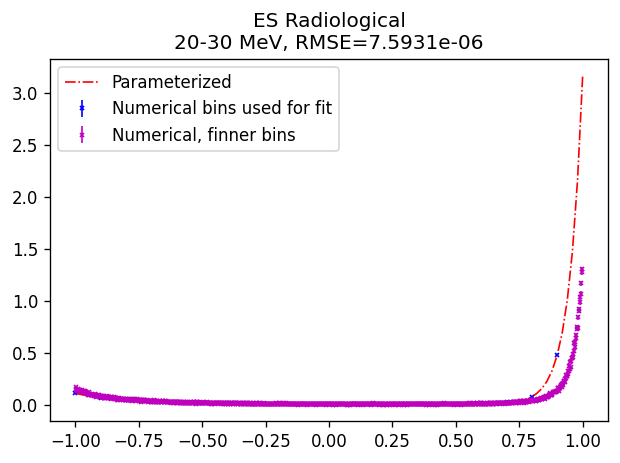

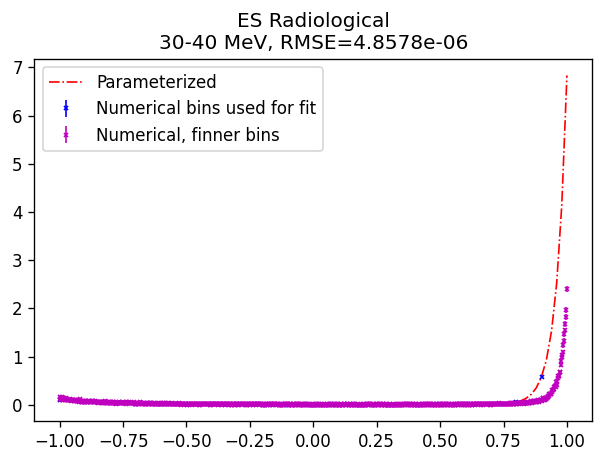

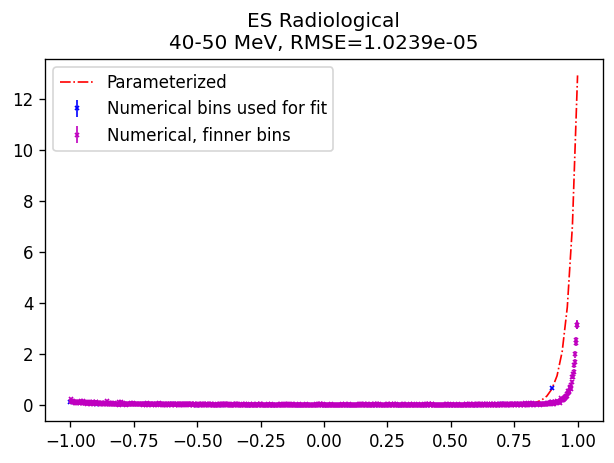

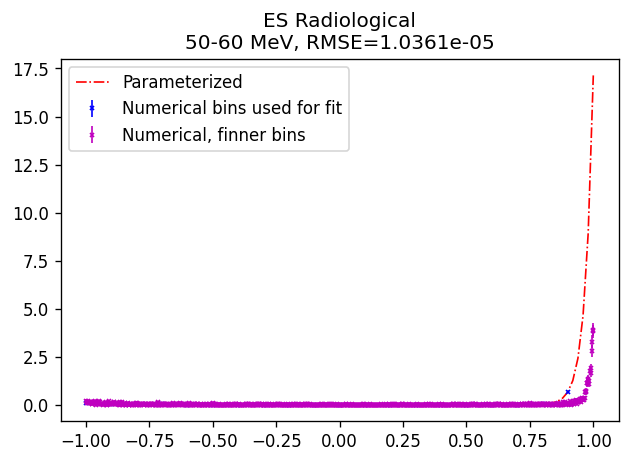

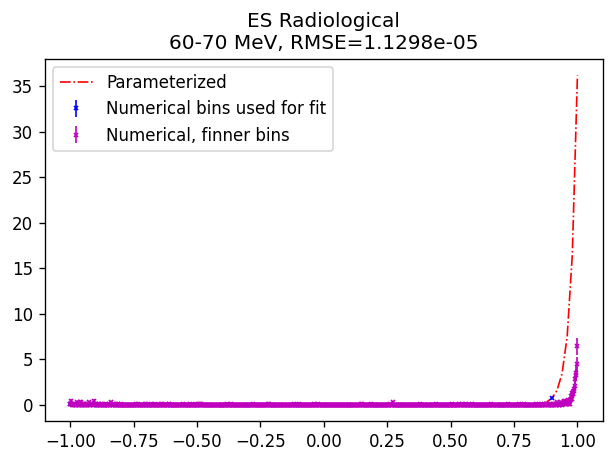

In [46]:
def bi_peak_distribution(x, g1, g2, sigma_1, sigma_2, c):
    return g1 * np.exp(- (x+1)/sigma_1) + g2 * np.exp((x-1)/sigma_2)+c
    # return g1 * np.exp(-((x+1)/sigma_1)**2) + g2 * np.exp(-((x-1)/sigma_2)**2)

def integral(g1, g2, sigma_1, sigma_2, c):
    return 2*c + g1 * (1 - np.exp(-2/sigma_1))*sigma_1 + g2 * (1 - np.exp(-2/sigma_2))* sigma_2

linspace = np.linspace(-1, 1, 100)
bin_left_edge = np.linspace(-1, 1, num=20, endpoint=False)
bin_left_edge_fine = np.linspace(-1, 1, num=1000, endpoint=False)+2/1000/2
for i, pdf_slice in enumerate(pdf):
    plt.figure(dpi=120)
    params, cov = curve_fit(bi_peak_distribution, bin_left_edge, pdf[i],
                            np.array([1, 1, 1, 1, 0], dtype=np.float128),
                            bounds=(np.array([0, 0, 0, 0, 0], dtype=np.float128),
                                    np.array([np.inf, np.inf, np.inf, np.inf, 0.1], dtype=np.float128)))
    rmse = np.mean((pdf_slice - bi_peak_distribution(bin_left_edge, *params)) ** 2)
    plt.plot(linspace, bi_peak_distribution(linspace, *params), 
             'r-.', linewidth=1,
             label="Parameterized")
    plt.errorbar(bin_left_edge, pdf[i], yerr = pdf_error[i], 
                 fmt='bx',ms=2, elinewidth=1,
                 label="Numerical bins used for fit")
    plt.errorbar(bin_left_edge_fine, pdf_fine[i], yerr = pdf_fine_error[i], 
                 fmt='mx', ms=2, elinewidth=1,
                 label="Numerical, finner bins")
    plt.legend()
    plt.title(f"ES Radiological\n{i*10}-{(i+1)*10} MeV, RMSE={rmse:.4e}")
# plt.plot(x, bi_peak_distribution(x, 0.13, 0.4, 5, 10))

In [38]:
matrix = np.zeros((5, 4))
matrix[0] = np.ones(4)
print(matrix)

[[1. 1. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [8]:
!pip list --outdated

Package  Version Latest Type
-------- ------- ------ -----
docutils 0.17.1  0.18.1 wheel
mistune  0.8.4   2.0.2  wheel
